In [2]:
import elevation.prediction_pipeline as pp
import elevation
import random
from sklearn.neighbors import NearestNeighbors
import numpy as np
import elevation
import pandas
import azimuth
import joblib
import logging
from joblib import Memory
from elevation.model_comparison import *
import copy
import scipy.stats as ss
from sklearn.grid_search import ParameterGrid
import sklearn.linear_model
import scipy as sp
import scipy.stats
import elevation.models
import elevation.features
#import GPy
import socket
from elevation.stacker import *
import elevation.util as ut
from sklearn.metrics import auc, roc_curve
from elevation import settings
import sklearn.isotonic
from sklearn.cross_validation import StratifiedKFold
import sklearn.pipeline
import sklearn.preprocessing
import pandas as pd
from elevation.cmds.predict import Predict
from elevation import options

In [3]:
import os
import pickle

In [4]:
%matplotlib inline

In [5]:
import matplotlib

In [6]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve,average_precision_score

In [7]:
def filter_pam_out_of_muts(data, i):
    tmp_muts = data['mut positions'].iloc[i]
    # because Hsu-Zhang ignores alternate PAMs which we have encoded with '22'
    pam_pos = 22
    if pam_pos in tmp_muts:
        tmp_muts.remove(pam_pos)
    tmp_muts = np.array(tmp_muts)
    num_m = len(tmp_muts)
    return num_m, tmp_muts

def predict(model, data, learn_options, learn_options_override=None, verbose=False):
    if learn_options_override is None:
        learn_options_override = learn_options
    predictions, model, learn_options, _tmpdata, feature_names, all_predictions_ind = predict_elevation(data=data, model=(model, learn_options), model_file=None, pam_audit=False, learn_options_override=learn_options_override,force_zero_intercept=False, naive_bayes_combine=True, verbose=verbose)
    return predictions, all_predictions_ind


class Smote:
    """
    SMOTE


    Parameters:
    -----------
    k: int
        the num.
    sampling_rate: int
        , attention sampling_rate < k.
    newindex: int
        
    """

    def __init__(self, sampling_rate=5, k=5):
        self.sampling_rate = sampling_rate
        self.k = k
        self.newindex = 0
    
    # 
    def synthetic_samples(self, X, i, k_neighbors,y=None):
        for j in range(self.sampling_rate):
            # 
            neighbor = np.random.choice(k_neighbors)
            # 
            diff = X[neighbor] - X[i]
            # 
            self.synthetic_X[self.newindex] = X[i] + random.random() * diff
            self.synthetic_y[self.newindex]=y[i]+random.random()*(y[neighbor]-y[i])
            self.newindex += 1

    def fit(self, X, y=None):
        if y is not None:
            negative_X = X[y == 0]
            X = X[y != 0]

        n_samples, n_features = X.shape
        # 
        self.synthetic_X = np.zeros((n_samples * self.sampling_rate, n_features))
        self.synthetic_y=np.zeros(n_samples*self.sampling_rate)

        # 
        knn = NearestNeighbors(n_neighbors=self.k).fit(X)
        for i in range(len(X)):
            print(i)
            k_neighbors = knn.kneighbors(X[i].reshape(1, -1),
                                         return_distance=False)[0]
            #
            # sampling_rate
            self.synthetic_samples(X, i, k_neighbors,y)

        if y is not None:
            return (np.concatenate((self.synthetic_X, X, negative_X), axis=0),
                    np.concatenate((self.synthetic_y, y[y!=0], y[y == 0]), axis=0))

def stacked_predictions(data, preds_base_model, models=['product', 'CFD', 'constant-power', 'linear-raw-stacker', 'linreg-stacker', 'RF-stacker', 'GP-stacker', 'raw GP'],
                        truth=None, guideseq_data=None, preds_guideseq=None, prob_calibration_model=None, learn_options=None, return_model=False, trained_model=None,
                        models_to_calibrate=None, return_residuals=False):#, dnase_train=None, dnase_test=None):

    predictions = dict([(m, None) for m in models])

    num_mismatches = np.array([len(t) for t in data["Annotation"].values])

    # if ('use_mut_distances' in learn_options.keys() and learn_options['use_mut_distances']):
    data = elevation.features.extract_mut_positions_stats(data)

    if guideseq_data is not None:
        y = guideseq_data['GUIDE-SEQ Reads'].values[:, None]
        num_annot = np.array([len(t) for t in guideseq_data["Annotation"].values])

    if 'logistic stacker' in models:
        X = preds_guideseq.copy()
        Xtest = preds_base_model.copy()
        m = Stacker(y, X, warp_out=False)
        m.maximize()
        predictions['logistic stacker'] = m.predict(Xtest)

    if 'CFD' in models:
        # predicting
        if 'cfd_table_file' not in learn_options.keys():
            learn_options['cfd_table_file'] = settings.pj(settings.offtarget_data_dir, "STable 19 FractionActive_dlfc_lookup.xlsx")

        cfd = elevation.models.CFDModel(cfd_table_file=learn_options['cfd_table_file'])
        
        predictions['CFD'] = cfd.predict(data["Annotation"].values, learn_options["num_proc"])[:, None]

    if 'product' in models:
        predictions['product'] = np.nanprod(preds_base_model, axis=1)[:,None]

    if 'constant-power' in models:
        predictions['constant-power'] = np.power(0.5, num_mismatches)

    if 'CCTOP' in models:
        # predicting
        term1 = np.zeros((data.shape[0], 1))
        for i in range(len(term1)):
            num_m, tmp_muts = filter_pam_out_of_muts(data, i)
            term1[i] = np.sum(1.2**np.array(tmp_muts))
        predictions['CCTOP'] = -term1.flatten()

    if 'HsuZhang' in models:

        # predicting
        W = [0.0,0.0,0.014,0.0,0.0,0.395,0.317,0,0.389,0.079,0.445,0.508,0.613,0.851,0.732,0.828,0.615,0.804,0.685,0.583]
        pred = np.zeros((data.shape[0], 1))

        for i in range(len(pred)):
            num_m, tmp_muts = filter_pam_out_of_muts(data, i)

            if len(tmp_muts) == 0:
                pred[i] = 1.0
            else:
                d = ut.get_pairwise_distance_mudra(tmp_muts)
                term1 = np.prod(1. - np.array(W)[tmp_muts - 1])

                if num_m > 1:
                    term2 = 1./(((19-d)/19)*4 + 1)
                else:
                    term2 = 1

                term3 = 1./(num_m)**2
                pred[i] = term1*term2*term3

        predictions['HsuZhang'] = pred.flatten()

    if 'linear-raw-stacker' in models or 'GBRT-raw-stacker' in models:

        if trained_model is None:
            # put together the training data
            X = preds_guideseq.copy()
            X[np.isnan(X)] = 1.0
            feature_names = ['pos%d' % (i+1) for i in range(X.shape[1])]
            # adding product, num. annots and sum to log of itself
            X = np.concatenate((np.log(X), np.prod(X, axis=1)[:, None], num_annot[:, None], np.sum(X, axis=1)[:, None]), axis=1)
            feature_names.extend(['product', 'num. annotations', 'sum'])
            # X = np.log(X)

            # Only product
            # X = np.prod(X, axis=1)[:, None]
            # feature_names = ['product']

        Xtest = preds_base_model.copy()
        Xtest[np.isnan(Xtest)] = 1.0
        Xtest = np.concatenate((np.log(Xtest), np.prod(Xtest, axis=1)[:, None],  num_mismatches[:, None],  np.sum(Xtest, axis=1)[:, None]), axis=1)
        # Xtest = np.log(Xtest)
        # Xtest = np.prod(Xtest, axis=1)[:, None]

        if ('use_mut_distances' in learn_options.keys() and learn_options['use_mut_distances']):
            guideseq_data = elevation.features.extract_mut_positions_stats(guideseq_data)
            X_dist = guideseq_data[['mut mean abs distance', 'mut min abs distance', 'mut max abs distance', 'mut sum abs distance',
                                    'mean consecutive mut distance', 'min consecutive mut distance', 'max consecutive mut distance',
                                    'sum consecutive mut distance']].values
            Xtest_dist = data[['mut mean abs distance', 'mut min abs distance', 'mut max abs distance', 'mut sum abs distance',
                          'mean consecutive mut distance', 'min consecutive mut distance', 'max consecutive mut distance',
                          'sum consecutive mut distance']].values
            X = np.concatenate((X, X_dist), axis=1)
            Xtest = np.concatenate((Xtest, Xtest_dist), axis=1)


        if 'azimuth_score_in_stacker' in learn_options.keys() and learn_options['azimuth_score_in_stacker']:
            azimuth_score = elevation.model_comparison.get_on_target_predictions(guideseq_data, ['WT'])[0]
            X = np.concatenate((X, azimuth_score[:, None]), axis=1)

            azimuth_score_test = elevation.model_comparison.get_on_target_predictions(data, ['WT'])[0]
            Xtest = np.concatenate((Xtest, azimuth_score_test[:, None]), axis=1)

        if 'linear-raw-stacker' in models:
                        
            dnase_type = [key for key in learn_options.keys() if 'dnase' in key]
            assert len(dnase_type) <= 1            
            if len(dnase_type) == 1:
                dnase_type = dnase_type[0]
                use_dnase = learn_options[dnase_type]
            else:
                use_dnase = False                           

            if use_dnase:
                
                dnase_train = guideseq_data["dnase"].values
                dnase_test = data["dnase"].values
                assert dnase_train.shape[0] == X.shape[0]
                assert dnase_test.shape[0] == Xtest.shape[0]
                     
                if dnase_type == 'dnase:default':
                    # simple appending (Melih)     
                    X = np.concatenate((X, dnase_train[:, None]), axis=1)
                    Xtest = np.concatenate((Xtest, dnase_test[:, None]), axis=1)

                elif dnase_type == 'dnase:interact':
                # interaction with original features
                    X = np.concatenate((X, X*dnase_train[:, None]), axis=1)
                    Xtest = np.concatenate((Xtest, Xtest*dnase_test[:, None]), axis=1)

                elif dnase_type == 'dnase:only':
                    # use only the dnase                                
                    X = dnase_train[:, None]
                    Xtest = dnase_test[:, None]                

                elif dnase_type == 'dnase:onlyperm':
                    # use only the dnase                                
                    pind = np.random.permutation(dnase_train.shape[0])
                    pind_test = np.random.permutation(dnase_test.shape[0])
                    X = dnase_train[pind, None]
                    Xtest = dnase_test[pind_test, None]                
                else:
                    raise NotImplementedError("no such dnase type: %s" % dnase_type)

            normX = True
            strength = 1.0

            # train the model
            if trained_model is None:
                
                # subsample the data for more balanced training
                                
                ind_zero = np.where(y==0)[0]
                ind_keep = (y!=0).flatten()  
                nn = ind_keep.sum()              
                # take every kth' zero
                increment = int(ind_zero.shape[0]/float(nn))
                sampling_rate=increment-1  #比例的选择
                k=20                    #k近邻的选择
                smote = Smote(sampling_rate=sampling_rate, k=k)
                X,y=smote.fit(X,y.flatten())     #进行smote的变换后得到的数据
                print X.shape
                print y.shape
                y=y.reshape(len(y),1)
                #----- debug
                #ind_zero = np.where(y==0)[0]
                #ind_keep2 = (y!=0).flatten()                
                #ind_keep2[np.random.permutation(ind_zero)[0:nn]] = True
                #-----

                # from IPython.core.debugger import Tracer; Tracer()()
                # what been using up until 9/12/2016
                #clf = sklearn.linear_model.LassoCV(cv=10, fit_intercept=True, normalize=True)

                # now using this:
                num_fold = 10

                kfold = StratifiedKFold(y.flatten()==0, num_fold, random_state=learn_options['seed'])
                #kfold2 = StratifiedKFold(y[ind_keep2].flatten()==0, num_fold, random_state=learn_options['seed'])

                clf = sklearn.linear_model.LassoCV(cv=kfold, fit_intercept=True, normalize=(~normX),n_jobs=num_fold, random_state=learn_options['seed'])
                #clf2 = sklearn.linear_model.LassoCV(cv=kfold2, fit_intercept=True, normalize=(~normX),n_jobs=num_fold, random_state=learn_options['seed'])
                
                if normX:
                    clf = sklearn.pipeline.Pipeline([['scaling', sklearn.preprocessing.StandardScaler()], ['lasso', clf]])
                    #clf2 = sklearn.pipeline.Pipeline([['scaling', sklearn.preprocessing.StandardScaler()], ['lasso', clf2]])

                #y_transf = st.boxcox(y[ind_keep] - y[ind_keep].min() + 0.001)[0]                
                
                # scale to be between 0 and 1 first
                y_new = (y - np.min(y)) / (np.max(y) - np.min(y))
                #plt.figure(); plt.plot(y_new[ind_keep], '.'); 
                y_transf = st.boxcox(y_new - y_new.min() + 0.001)[0]                
                
                # when we do renormalize, we konw that these values are mostly negative (see Teams on 6/27/2017),
                # so lets just make them go entirely negative(?)                
                #y_transf = y_transf - np.max(y_transf)
                
                #plt.figure(); plt.plot(y_transf, '.'); #plt.title("w out renorm, w box cox, then making all negative"); plt.show()
                #import ipdb; ipdb.set_trace()


                #y_transf = np.log(y[ind_keep] - y[ind_keep].min() + 0.001)               
                #y_transf = y[ind_keep]

                # debugging
                #y_transf2 = st.boxcox(y[ind_keep2] - y[ind_keep2].min() + 0.001)[0]
                #y_transf2 = y[ind_keep2]

                print "train data set size is N=%d" % len(y_transf)
                clf.fit(X, y_transf)                 
                #clf2.fit(X[ind_keep2], y_transf2) 
                #clf.fit(X_keep, tmpy) 
                
                #tmp = clf.predict(X)
                #sp.stats.spearmanr(tmp[ind_keep],y_transf.flatten())[0]
                #sp.stats.spearmanr(tmp[ind_keep], y[ind_keep])[0]
                #sp.stats.spearmanr(tmp, y)[0]
                #sp.stats.pearsonr(tmp[ind_keep],y_transf.flatten())[0]
                                       

                # clf.fit(X, y.flatten())
                # clf.fit(X, y, sample_weight=weights)
            else:
                clf = trained_model

            # if normX:
            #    predictions['linear-raw-stacker'] = clf.predict(normalizeX(Xtest, strength, None))
            # else:
            predictions['linear-raw-stacker'] = clf.predict(Xtest)
            # residuals = np.log(y[ind_keep].flatten()+0.001) - clf.predict(X[ind_keep])

    if 'linreg-stacker' in models:
        m_stacker = StackerFeat()
        m_stacker.fit(preds_guideseq, y, model='linreg', normalize_feat=False)
        predictions['linreg-stacker'] = m_stacker.predict(preds_base_model)

    if 'RF-stacker' in models:
        m_stacker = StackerFeat()
        m_stacker.fit(preds_guideseq, y, model='RFR', normalize_feat=False)
        predictions['RF-stacker'] = m_stacker.predict(preds_base_model)

    if 'GP-stacker'in models:
        m_stacker = StackerFeat()
        m_stacker.fit(preds_guideseq, y, model='GP', normalize_feat=False)
        predictions['GP-stacker'] = m_stacker.predict(preds_base_model)

    if 'raw GP' in models:
        X = preds_guideseq.copy()
        X[np.isnan(X)] = 1.0
        D_base_predictions = X.shape[1]
        X = np.concatenate((np.prod(X, axis=1)[:, None],
                            num_annot[:, None],
                            np.sum(X, axis=1)[:, None],
                            X),  axis=1)

        Xtest = preds_base_model.copy()
        Xtest[np.isnan(Xtest)] = 1.0
        Xtest = np.concatenate((np.prod(Xtest, axis=1)[:, None],
                                num_mismatches[:, None],
                                np.sum(Xtest, axis=1)[:, None],
                                Xtest), axis=1)

        K = GPy.kern.RBF(1, active_dims=[0]) + GPy.kern.RBF(1, active_dims=[1]) + GPy.kern.Linear(1, active_dims=[2]) + GPy.kern.RBF(D_base_predictions, active_dims=range(3, D_base_predictions+3))
        m = GPy.models.GPRegression(X, np.log(y), kernel=K)
        m.optimize_restarts(5, messages=0)
        predictions['raw GP'] = m.predict(Xtest)[0]

    if 'combine' in models:
        predictions['combine'] = np.ones_like(predictions[predictions.keys()[0]])

        for c_model in models:
            if c_model != 'combine':
                predictions['combine'] += predictions[c_model].flatten()[:, None]
        predictions['combine'] /= len(models)-1

    if 'ensemble' in models:
        predictions['ensemble'] = (predictions['product'].flatten() + predictions['linear-raw-stacker'].flatten())/2.


    if prob_calibration_model is not None:

        if models_to_calibrate is None:
            models_to_calibrate = ['linear-raw-stacker']

        for m in models:

            if False:# m == 'linear-raw-stacker':
                pred = np.exp(predictions[m].flatten()[:, None]) - 0.001 # undo log transformation
            else:
                pred = predictions[m].flatten()[:, None]

            if m in models_to_calibrate:

                cal_pred = prob_calibration_model[m].predict_proba(pred)[:, 1]
                #cal_pred = prob_calibration_model[m].predict_proba(pred)[:, 0]

                if len(pred) > 10:
                    assert np.allclose(sp.stats.spearmanr(pred, cal_pred)[0], 1.0)# or np.allclose(sp.stats.spearmanr(pred, cal_pred)[0], -1.0)

                predictions[m] = cal_pred

    if truth is not None:
        res_str = "Spearman r: "
        for m in models:
            res_str += "%s=%.3f " % (m, sp.stats.spearmanr(truth, predictions[m])[0])
        print res_str

        res_str = "NDCG: "
        for m in models:
            res_str += "%s=%.3f " % (m, azimuth.metrics.ndcg_at_k_ties(truth.values.flatten(), predictions[m].flatten(), truth.shape[0]))
        print res_str

    if return_model:
        if return_residuals:
            return predictions, clf, feature_names, residuals
        else:
            return predictions, clf, feature_names

    return predictions
def train_prob_calibration_model(cd33_data, guideseq_data, preds_guideseq, base_model, learn_options, which_stacker_model='linear-raw-stacker', other_calibration_models=None):
    assert which_stacker_model == 'linear-raw-stacker', "only LRS can be calibrated right now"
    # import ipdb; ipdb.set_trace()

    # if cd33_data is not None:
    Y_bin = cd33_data['Day21-ETP-binarized'].values
    Y = cd33_data['Day21-ETP'].values
    # else:
    #     ind = np.zeros_like(guideseq_data['GUIDE-SEQ Reads'].values)
    #     ind[guideseq_data['GUIDE-SEQ Reads'].values > 0] = True
    #     ind_zero = np.where(guideseq_data['GUIDE-SEQ Reads'].values==0)[0]
    #     ind[ind_zero[::ind_zero.shape[0]/float(ind.sum())]] = True
    #     ind = ind==True
    #     Y = guideseq_data[ind]['GUIDE-SEQ Reads'].values
    #     cd33_data = guideseq_data[ind]

    #X_guideseq = predict(base_model, cd33_data, learn_options)[0]
    nb_pred, individual_mut_pred_cd33 = predict(base_model, cd33_data, learn_options)

    # # This the models in the ensemble have to be calibrated as well, so we rely on
    # # having previously-calibrated models available in a dictionary
    # if which_model == 'ensemble':
    #     models = ['CFD', 'HsuZhang', 'product', 'linear-raw-stacker', 'ensemble']
    #     models_to_calibrate = ['product', 'linear-raw-stacker']
    #     calibration_models = other_calibration_models
    # else:
    #     models = [which_model]
    #     models_to_calibrate = None
    #     calibration_models = None

    # get linear-raw-stacker (or other model==which_model) predictions, including training of that model if appropriate (e.g. linear-raw-stacker)
    X_guideseq, clf_stacker_model, feature_names_stacker_model = stacked_predictions(cd33_data, individual_mut_pred_cd33,
                                     models=[which_stacker_model],
                                     guideseq_data=guideseq_data,
                                     preds_guideseq=preds_guideseq,
                                     learn_options=learn_options,
                                     models_to_calibrate=None,
                                     prob_calibration_model=None,
                                     return_model=True)
    X_guideseq = X_guideseq[which_stacker_model]

    clf = sklearn.linear_model.LogisticRegression(fit_intercept=True, solver='lbfgs')

    # fit the linear-raw-stacker (or whatever model is being calibrated) predictions on cd33 to the actual binary cd33 values    
    clf.fit(X_guideseq[:, None], Y_bin)    
    y_pred = clf.predict_proba(X_guideseq[:, None])[:, 1]
    #y_pred = clf.predict_proba(X_guideseq[:, None])[:, 0]

    #import ipdb; ipdb.set_trace()

    expected_sign = np.sign(sp.stats.spearmanr(X_guideseq, Y_bin)[0])
    assert np.allclose(sp.stats.spearmanr(y_pred, X_guideseq)[0], 1.0*expected_sign, atol=1e-2)

    return clf

def excute(wildtype, offtarget,calibration_models,base_model,guideseq_data,preds_guideseq,learn_options):     #编写测试的函数
    start = time.time()
    wt = wildtype
    mut = offtarget
    df = pd.DataFrame(columns=['30mer', '30mer_mut', 'Annotation'], index=range(len(wt)))
    df['30mer'] = wt
    df['30mer_mut'] = mut
    annot = []
    for i in range(len(wt)):
        annot.append(elevation.load_data.annot_from_seqs(wt[i], mut[i]))
    df['Annotation'] = annot
       # print "Time spent parsing input: ", time.time() - start

    base_model_time = time.time()
    nb_pred, individual_mut_pred = elevation.prediction_pipeline.predict(base_model, df, learn_options)
        #print "Time spent in base model predict(): ", time.time() - base_model_time

    start = time.time()
    pred = stacked_predictions(df, individual_mut_pred,
                                                     learn_options=learn_options,
                                                     guideseq_data=guideseq_data,
                                                     preds_guideseq=preds_guideseq,
                                                     prob_calibration_model=calibration_models,
                                                     models=['HsuZhang', 'CFD', 'CCTOP', 'linear-raw-stacker'])
    return pred

In [8]:
#画pr的曲线:
def test_pr(predictions,truth,listmodel,listcolor,save_name):
    plt.figure()
    for i in range(len(listmodel)):
        model=listmodel[i]
        color=listcolor[i]
        precision, recall, thresholds = precision_recall_curve(truth.flatten(), predictions[model].flatten())
        model_ave_precision = average_precision_score(truth, predictions[model])
        plt.plot(recall,precision,label=model+"(%.3f" % model_ave_precision+")",color=color,lw=2)
    plt.legend(loc=0)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.savefig(save_name,dpi=300)

In [9]:
#画auc的曲线
def test_roc(predictions, truth,listmodel,listcolor,name):
    plt.figure()
    for i in range(len(listmodel)):
        model=listmodel[i]
        color=listcolor[i]
        fpr, tpr, thresholds = roc_curve(truth.flatten(), predictions[model].flatten())
        model_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=model+"(%.3f" % model_auc+")",color=color,lw=2)
    plt.legend(loc=0)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',
         label='Base Line', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.savefig(name,dpi=300)

In [10]:
listmodel=['Elevation-score_with_smote','Elevation-score','HsuZhang','CFD','CCTOP']
listcolor=['blue','purple','green','red','orange']

In [11]:
#train_final_model
learn_options=options.learn_options
base_model, base_feature_names=pp.train_base_model(learn_options)
guideseq_data=pp.load_guideseq(learn_options, False, False)
preds_guideseq=pp.predict_guideseq(base_model, guideseq_data, learn_options, True)
cd33_data=elevation.load_data.load_cd33(learn_options)
cd33_data = cd33_data[0]
cd33_data['Annotation'] = cd33_data['Annotation'].apply(lambda x: [x])
to_be_calibrated = 'linear-raw-stacker'
calibration_models = {}
calibration_models[to_be_calibrated]=train_prob_calibration_model(cd33_data,guideseq_data,preds_guideseq,base_model,learn_options,which_stacker_model=to_be_calibrated,other_calibration_models=calibration_models)

Received option CV=False, so I'm training using all of the data
running AdaBoost, order 1 for final
Launching 8 jobs with 3 MKL threads each
reading and featurizing CD33 data...


/home/gyl/Elevation/elevation/load_data.py:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['Position'][np.isnan(data['Position'])] = -1
/home/gyl/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


generating 30 and 32 mer sequences for 20mer guides and saving to file
done 0 of 4853
done 100 of 4853
done 200 of 4853
done 300 of 4853
done 400 of 4853
done 500 of 4853
done 600 of 4853
done 700 of 4853
done 800 of 4853
done 900 of 4853
done 1000 of 4853
done 1100 of 4853
done 1200 of 4853
done 1300 of 4853
done 1400 of 4853
done 1500 of 4853
done 1600 of 4853
done 1700 of 4853
done 1800 of 4853
done 1900 of 4853
done 2000 of 4853
done 2100 of 4853
done 2200 of 4853
done 2300 of 4853
done 2400 of 4853
done 2500 of 4853
done 2600 of 4853
done 2700 of 4853
done 2800 of 4853
done 2900 of 4853
done 3000 of 4853
done 3100 of 4853
done 3200 of 4853
done 3300 of 4853
done 3400 of 4853
done 3500 of 4853
done 3600 of 4853
done 3700 of 4853
done 3800 of 4853
done 3900 of 4853
done 4000 of 4853
done 4100 of 4853
done 4200 of 4853
done 4300 of 4853
done 4400 of 4853
done 4500 of 4853
done 4600 of 4853
done 4700 of 4853
done 4800 of 4853
Done.
{'bandwidth': 0.23000000000000001}
featurizing data..

/home/gyl/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
guideseq_data

,Targetsite,Num mismatches,GUIDE-SEQ Reads,30mer,30mer_mut,chromosome,start,end,gene,strand,Category,Annotation,20mer
0,VEGFA_site1,2,0.386461,GGGTGGGGGGAGTTTGCTCCTGG,GGATGGAGGGAGTTTGCTCCTGG,15,65345193,65345217,IGDCC3,-,SomeTypeMutation,"[A:G,3, A:G,7]",GGGTGGGGGGAGTTTGCTCC
1,VEGFA_site3,2,0.173872,GGTGAGTGAGTGTGTGCGTGGGG,AGTGAGTGAGTGTGTGTGTGGGG,14,65102435,65102459,MAX,-,SomeTypeMutation,"[A:G,1, T:C,17]",GGTGAGTGAGTGTGTGCGTG
2,EMX1,2,0.485692,GAGTCCGAGCAGAAGAAGAAAGG,GAGTTAGAGCAGAAGAAGAAAGG,5,45358959,45358983,HCN1,-,SomeTypeMutation,"[T:C,5, A:C,6]",GAGTCCGAGCAGAAGAAGAA
3,VEGFA_site3,3,0.142380,GGTGAGTGAGTGTGTGCGTGAGG,AGAGAGTGAGTGTGTGCATGAGG,5,90145146,90145170,NoGene,-,SomeTypeMutation,"[A:G,1, A:T,3, A:G,18]",GGTGAGTGAGTGTGTGCGTG
4,HEK293_sgRNA4,3,0.109805,GGCACTGCGGCTGGAGGTGGTGG,TGCACTGCGGCCGGAGGAGGTGG,20,61435490,61435514,CDH4,+,SomeTypeMutation,"[T:G,1, C:T,12, A:T,18]",GGCACTGCGGCTGGAGGTGG
5,VEGFA_site3,2,0.122406,GGTGAGTGAGTGTGTGCGTGAGG,TGTGGGTGAGTGTGTGCGTGAGG,5,116098962,116098986,COMMD10,+,SomeTypeMutation,"[T:G,1, G:A,5]",GGTGAGTGAGTGTGTGCGTG
6,FANCF,2,0.682158,GGAATCCCTTCTGCAGCACCAGG,GGAACCCCGTCTGCAGCACCAGG,18,8707524,8707548,MTCL1,-,SomeTypeMutation,"[C:T,5, G:T,9]",GGAATCCCTTCTGCAGCACC
7,HEK293_sgRNA4,2,0.089618,GGCACTGCGGCTGGAGGTGGTGG,GGCTCTGCGGCTGGAGGGGGTGG,19,32891169,32891193,CEP89,-,SomeTypeMutation,"[T:A,4, G:T,18]",GGCACTGCGGCTGGAGGTGG
8,VEGFA_site3,2,0.111111,GGTGAGTGAGTGTGTGCGTGTGG,GCTGAGTGAGTGTATGCGTGTGG,22,37266777,37266801,NoGene,-,SomeTypeMutation,"[C:G,2, A:G,14]",GGTGAGTGAGTGTGTGCGTG
9,VEGFA_site1,4,0.231017,GGGTGGGGGGAGTTTGCTCCTGG,TAGTGGAGGGAGCTTGCTCCTGG,17,41640070,41640094,NoGene,-,SomeTypeMutation,"[T:G,1, A:G,2, A:G,7, C:T,13]",GGGTGGGGGGAGTTTGCTCC


In [14]:
#进行测试集的厕所
#加载训练数据集
RNA_5g=pd.read_csv("5gRNA_final-contain-read_data.tab",header=None)

In [15]:
wildtype_5g=list(RNA_5g.iloc[:,0])
offtarget_5g=list(RNA_5g.iloc[:,1])
read_5g=np.array(RNA_5g.iloc[:,2])
class_5g=np.array(RNA_5g.iloc[:,3])

In [16]:
preds_smote=excute(wildtype_5g, offtarget_5g,calibration_models,base_model,guideseq_data,preds_guideseq,learn_options)

predict_elevation allocating 28 cores
start_range=0, end_range=9999
predict_elevation: 0.00 perc. done (0 of 312113 using block_size=10000) 
start_range=10000, end_range=19999
predict_elevation: 3.20 perc. done (10000 of 312113 using block_size=10000) 
start_range=20000, end_range=29999
predict_elevation: 6.41 perc. done (20000 of 312113 using block_size=10000) 
start_range=30000, end_range=39999
predict_elevation: 9.61 perc. done (30000 of 312113 using block_size=10000) 
start_range=40000, end_range=49999
predict_elevation: 12.82 perc. done (40000 of 312113 using block_size=10000) 
start_range=50000, end_range=59999
predict_elevation: 16.02 perc. done (50000 of 312113 using block_size=10000) 
start_range=60000, end_range=69999
predict_elevation: 19.22 perc. done (60000 of 312113 using block_size=10000) 
start_range=70000, end_range=79999
predict_elevation: 22.43 perc. done (70000 of 312113 using block_size=10000) 
start_range=80000, end_range=89999
predict_elevation: 25.63 perc. done 

/home/gyl/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/gyl/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/home/gyl/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
preds_smote

{'CCTOP': array([ -0.        , -69.14691721, -10.59808371, ..., -49.82433412,
        -63.91988547, -74.69661516]), 'CFD': array([[  1.00000000e+00],
        [  5.42410714e-01],
        [  9.93055555e-02],
        ..., 
        [  4.75308637e-04],
        [  1.19345984e-02],
        [  1.13960113e-04]]), 'HsuZhang': array([  1.00000000e+00,   1.19835375e-03,   1.62713146e-02, ...,
          1.50312392e-03,   9.45748460e-05,   2.70107539e-04]), 'linear-raw-stacker': array([  9.98747505e-01,   6.89685240e-03,   2.92683726e-03, ...,
          2.13103106e-04,   2.82745936e-04,   7.40520421e-05])}

In [19]:
preds_smote.keys()

['CFD', 'linear-raw-stacker', 'CCTOP', 'HsuZhang']

In [21]:
preds_smote.update(Elevation_with_smote=preds_smote.pop('elevation_w'))

In [22]:
p1=Predict()
preds_1=p1.execute(wildtype_5g,offtarget_5g)

from get_or_compute reading cached pickle /home/gyl/Elevation/tmp/base_model.pkl
from get_or_compute reading cached pickle /home/gyl/Elevation/tmp/guideseq_data.pkl
from get_or_compute reading cached pickle /home/gyl/Elevation/tmp/gspred.pkl
from get_or_compute reading cached pickle /home/gyl/Elevation/tmp/cd33.pkl
from get_or_compute reading cached pickle /home/gyl/Elevation/tmp/calibration_models.pkl
Time spent loading pickles:  18.3361108303
Time spent parsing input:  6.21479487419
predict_elevation allocating 28 cores
start_range=0, end_range=9999
predict_elevation: 0.00 perc. done (0 of 312113 using block_size=10000) 
start_range=10000, end_range=19999
predict_elevation: 3.20 perc. done (10000 of 312113 using block_size=10000) 
start_range=20000, end_range=29999
predict_elevation: 6.41 perc. done (20000 of 312113 using block_size=10000) 
start_range=30000, end_range=39999
predict_elevation: 9.61 perc. done (30000 of 312113 using block_size=10000) 
start_range=40000, end_range=4999

/home/gyl/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/gyl/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


Time spent in stacked_predictions:  381.031823158


In [33]:

preds_smote["Elevation-score_with_smote"]=preds_smote["linear-raw-stacker"]
preds_smote.pop('linear-raw-stacker')

array([  9.98747505e-01,   6.89685240e-03,   2.92683726e-03, ...,
         2.13103106e-04,   2.82745936e-04,   7.40520421e-05])

In [35]:
preds_smote.keys()

['CFD', 'CCTOP', 'HsuZhang', 'Elevation-score_with_smote']

In [36]:
preds_smote['Elevation-score']=preds_1["linear-raw-stacker"]

In [37]:
preds_with_smote_5g=preds_smote

In [39]:
preds_with_smote_5g.keys()                                       #d.update(y=d.pop('a'))

['CFD', 'Elevation-score', 'CCTOP', 'HsuZhang', 'Elevation-score_with_smote']

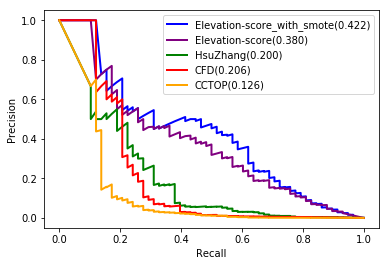

In [41]:
name='5sgRNAs_pr_smote'
test_pr(preds_with_smote_5g,class_5g,listmodel,listcolor,name)

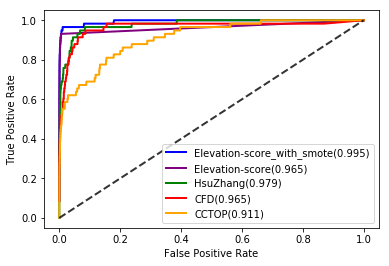

In [42]:
name='5sgRNAs_roc_smote'
test_roc(preds_with_smote_5g, class_5g,listmodel,listcolor,name)

In [43]:
#进行12gRNA的测试
RNA_12g=pd.read_csv("22gRNA_final-contain_data.tab",header=None)
wildtype_12g=list(RNA_22g.iloc[:,0])
offtarget_12g=list(RNA_22g.iloc[:,1])
read_12g=np.array(RNA_22g.iloc[:,2])
class_12g=np.array(RNA_2g.iloc[:,3])

In [44]:
preds_smote_12g=excute(wildtype_12g, offtarget_12g,calibration_models,base_model,guideseq_data,preds_guideseq,learn_options)

predict_elevation allocating 28 cores
start_range=0, end_range=9999
predict_elevation: 0.00 perc. done (0 of 749169 using block_size=10000) 
start_range=10000, end_range=19999
predict_elevation: 1.33 perc. done (10000 of 749169 using block_size=10000) 
start_range=20000, end_range=29999
predict_elevation: 2.67 perc. done (20000 of 749169 using block_size=10000) 
start_range=30000, end_range=39999
predict_elevation: 4.00 perc. done (30000 of 749169 using block_size=10000) 
start_range=40000, end_range=49999
predict_elevation: 5.34 perc. done (40000 of 749169 using block_size=10000) 
start_range=50000, end_range=59999
predict_elevation: 6.67 perc. done (50000 of 749169 using block_size=10000) 
start_range=60000, end_range=69999
predict_elevation: 8.01 perc. done (60000 of 749169 using block_size=10000) 
start_range=70000, end_range=79999
predict_elevation: 9.34 perc. done (70000 of 749169 using block_size=10000) 
start_range=80000, end_range=89999
predict_elevation: 10.68 perc. done (800

start_range=710000, end_range=719999
predict_elevation: 94.77 perc. done (710000 of 749169 using block_size=10000) 
start_range=720000, end_range=729999
predict_elevation: 96.11 perc. done (720000 of 749169 using block_size=10000) 
start_range=730000, end_range=739999
predict_elevation: 97.44 perc. done (730000 of 749169 using block_size=10000) 
start_range=740000, end_range=749168
predict_elevation: 98.78 perc. done (740000 of 749169 using block_size=10000) 
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
16

/home/gyl/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [90]:
#d.update(y=d.pop('a'))   #如何去改key的值

In [46]:
preds_smote_12g.keys()

['CFD', 'linear-raw-stacker', 'CCTOP', 'HsuZhang']

In [47]:
preds_12g=p1.execute(wildtype_12g ,offtarget_12g)

Time spent parsing input:  9.34324908257
predict_elevation allocating 28 cores
start_range=0, end_range=9999
predict_elevation: 0.00 perc. done (0 of 749169 using block_size=10000) 
start_range=10000, end_range=19999
predict_elevation: 1.33 perc. done (10000 of 749169 using block_size=10000) 
start_range=20000, end_range=29999
predict_elevation: 2.67 perc. done (20000 of 749169 using block_size=10000) 
start_range=30000, end_range=39999
predict_elevation: 4.00 perc. done (30000 of 749169 using block_size=10000) 
start_range=40000, end_range=49999
predict_elevation: 5.34 perc. done (40000 of 749169 using block_size=10000) 
start_range=50000, end_range=59999
predict_elevation: 6.67 perc. done (50000 of 749169 using block_size=10000) 
start_range=60000, end_range=69999
predict_elevation: 8.01 perc. done (60000 of 749169 using block_size=10000) 
start_range=70000, end_range=79999
predict_elevation: 9.34 perc. done (70000 of 749169 using block_size=10000) 
start_range=80000, end_range=89999

start_range=710000, end_range=719999
predict_elevation: 94.77 perc. done (710000 of 749169 using block_size=10000) 
start_range=720000, end_range=729999
predict_elevation: 96.11 perc. done (720000 of 749169 using block_size=10000) 
start_range=730000, end_range=739999
predict_elevation: 97.44 perc. done (730000 of 749169 using block_size=10000) 
start_range=740000, end_range=749168
predict_elevation: 98.78 perc. done (740000 of 749169 using block_size=10000) 
Time spent in base model predict():  1278.6902101
train data set size is N=709


/home/gyl/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Time spent in stacked_predictions:  916.382874012


In [ ]:
preds_smote_12g["Elevation-score_with_smote"]=preds_smote_12g['linear-raw-stacker']
preds_smote_12g.pop("linear-raw-stacker")
preds_smote_12g["Elevation-score"]=preds_12g["linear-raw-stacker"]

In [52]:
preds_smote_12g.keys()

['CFD', 'Elevation-score', 'CCTOP', 'HsuZhang', 'Elevation-score_with_smote']

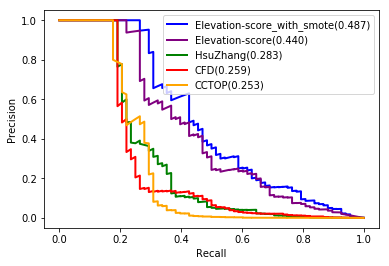

In [53]:
name='12sgRNAs_pr_smote'
test_pr(preds_smote_12g,class_12g,listmodel,listcolor,name)

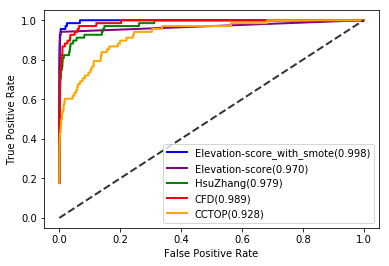

In [54]:
name='12sgRANs_roc_smote'
test_roc(preds_smote_12g, class_12g,listmodel,listcolor,name)